In [ ]:
import sys
sys.path.append('/storage/homefs/tf24s166/code/cifar10/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import nannyml as nml
from utils.datasets import CustomDataset
from torchvision.models import ResNet50_Weights
from IPython.display import display

In [69]:
# Get data
transform = transforms.Compose([
        transforms.Resize((224, 224)), # ResNet50 requires 224x224 images
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_set = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.7589979].


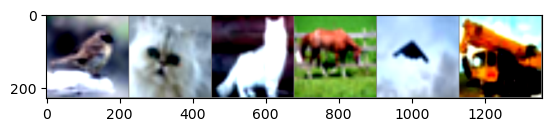

bird  cat   cat   horse plane truck


In [37]:
# Plot example images
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [54]:
model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(2048, 10)
model.load_state_dict(torch.load('/storage/homefs/tf24s166/code/cifar10/outputs/2024-11-19/09-37-09/best_model.pth', weights_only=True,
                                 map_location=torch.device('cpu') ))


<All keys matched successfully>

In [143]:
# Initialize an empty DataFrame
df = pd.DataFrame(columns=["label", "pred"]+[cl + '_prob' for cl in classes])

i = 0
for i, (image, label) in enumerate(testloader):
    print(f'Batch {i+1}/{len(testloader)}')
    model.eval()
    
    # Run model predictions
    pred = model(image)
    prediction = torch.argmax(pred, dim=1)
    pred_prob = torch.nn.functional.softmax(pred, dim=1).detach().numpy()

    #pred_prob = torch.max(pred_prob, dim=1).values.detach().numpy()
    
    # Append data to the DataFrame
    batch_data = pd.DataFrame({
        "label": label.numpy(),              # Convert label tensor to numpy
        "pred": prediction.numpy(),          # Convert prediction tensor to numpy
    })

    for i, class_name in enumerate(classes):
        batch_data[class_name + '_prob'] = pred_prob[:, i]
    df = pd.concat([df, batch_data], ignore_index=True)
    
# Display the resulting DataFrame
print(df.head())

Batch 1/79


/tmp/ipykernel_3369960/2917640919.py:24: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Batch 2/79
Batch 3/79
Batch 4/79
Batch 5/79
Batch 6/79
Batch 7/79
Batch 8/79
Batch 9/79
Batch 10/79
Batch 11/79
Batch 12/79
Batch 13/79
Batch 14/79
Batch 15/79
Batch 16/79
Batch 17/79
Batch 18/79
Batch 19/79
Batch 20/79
Batch 21/79
Batch 22/79
Batch 23/79
Batch 24/79
Batch 25/79
Batch 26/79
Batch 27/79
Batch 28/79
Batch 29/79
Batch 30/79
Batch 31/79
Batch 32/79
Batch 33/79
Batch 34/79
Batch 35/79
Batch 36/79
Batch 37/79
Batch 38/79
Batch 39/79
Batch 40/79
Batch 41/79
Batch 42/79
Batch 43/79
Batch 44/79
Batch 45/79
Batch 46/79
Batch 47/79
Batch 48/79
Batch 49/79
Batch 50/79
Batch 51/79
Batch 52/79
Batch 53/79
Batch 54/79
Batch 55/79
Batch 56/79
Batch 57/79
Batch 58/79
Batch 59/79
Batch 60/79
Batch 61/79
Batch 62/79
Batch 63/79
Batch 64/79
Batch 65/79
Batch 66/79
Batch 67/79
Batch 68/79
Batch 69/79
Batch 70/79
Batch 71/79
Batch 72/79
Batch 73/79
Batch 74/79
Batch 75/79
Batch 76/79
Batch 77/79
Batch 78/79
Batch 79/79
  label pred    plane_prob  car_prob  bird_prob  cat_prob  deer_prob  \


In [145]:
chunk_size = 50
estimator = nml.CBPE(
problem_type='classification_multiclass',
y_pred_proba={class_name : class_name + '_prob' for class_name in classes},
y_pred='pred',
y_true='label',
metrics=['f1'],
chunk_size=chunk_size,
)

In [146]:
df['label'] = df['label'].replace({i: class_name for i, class_name in enumerate(classes)})
df['pred'] = df['pred'].replace({i: class_name for i, class_name in enumerate(classes)})
reference_df = df[:int(len(df)*0.5)]
print(len(reference_df))
analysis_df = df[int(len(df)*0.5):]
display(reference_df.head())


5000


,label,pred,plane_prob,car_prob,bird_prob,cat_prob,deer_prob,dog_prob,frog_prob,horse_prob,ship_prob,truck_prob
0,cat,cat,7.257217e-05,0.000052,0.000063,0.997574,0.000009,2.079249e-03,0.000039,6.175623e-05,2.048156e-05,2.967378e-05
1,ship,ship,3.940283e-05,0.000736,0.000003,0.000005,0.000001,1.989946e-06,0.000005,2.311797e-06,9.992042e-01,2.995493e-06
2,ship,ship,2.601553e-05,0.000575,0.000002,0.000003,0.000002,1.052408e-06,0.000002,2.911062e-06,9.993796e-01,7.033589e-06
3,plane,plane,9.996296e-01,0.000001,0.000104,0.000194,0.000005,5.007200e-07,0.000011,1.903709e-06,4.179465e-05,1.007806e-05
4,frog,frog,5.146409e-07,0.000002,0.000011,0.000003,0.000005,1.325804e-06,0.999977,1.575557e-07,5.964413e-07,6.788940e-07


In [147]:
estimator.fit(reference_df)

#results = estimator.estimate(analysis_df)
#display(results.filter(period='analysis').to_df())

/storage/homefs/tf24s166/.conda/envs/performance_metrics/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/storage/homefs/tf24s166/.conda/envs/performance_metrics/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/storage/homefs/tf24s166/.conda/envs/performance_metrics/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/storage/homefs/tf24s166/.conda/envs/performance_metrics/lib/python3.10/site-packages/sklearn/metrics/_

In [150]:
results = estimator.estimate(analysis_df)
display(results.filter(period='analysis').to_df())
metric_fig = results.plot()
metric_fig.show()

/storage/homefs/tf24s166/.conda/envs/performance_metrics/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/storage/homefs/tf24s166/.conda/envs/performance_metrics/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/storage/homefs/tf24s166/.conda/envs/performance_metrics/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.



chunk                                                        \
            key chunk_index start_index end_index start_date end_date   
0        [0:49]           0        5000      5049       None     None   
1       [50:99]           1        5050      5099       None     None   
2     [100:149]           2        5100      5149       None     None   
3     [150:199]           3        5150      5199       None     None   
4     [200:249]           4        5200      5249       None     None   
..          ...         ...         ...       ...        ...      ...   
95  [4750:4799]          95        9750      9799       None     None   
96  [4800:4849]          96        9800      9849       None     None   
97  [4850:4899]          97        9850      9899       None     None   
98  [4900:4949]          98        9900      9949       None     None   
99  [4950:4999]          99        9950      9999       None     None   

                    f1                                                     \
      period     value sampling_error  realized upper_confidence_boundary   
0   analysis  0.978098       0.034003  0.985641                       1.0   
1   analysis  0.978385       0.034003  0.945909                       1.0   
2   analysis  0.979786       0.034003  1.000000                       1.0   
3   analysis  0.959174       0.034003  0.950515                       1.0   
4   analysis  0.967821       0.034003  0.957820                       1.0   
..       ...       ...            ...       ...                       ...   
95  analysis  0.966579       0.034003  0.976623                       1.0   
96  analysis  0.939516       0.034003  0.940952                       1.0   
97  analysis  0.967265       0.034003  0.944211                       1.0   
98  analysis  0.978076       0.034003  0.986667                       1.0   
99  analysis  0.984427       0.034003  0.985027                       1.0   

                                                                     
   lower_confidence_boundary upper_threshold lower_threshold  alert  
0                   0.876089               1        0.830631  False  
1                   0.876376               1        0.830631  False  
2                   0.877777               1        0.830631  False  
3                   0.857165               1        0.830631  False  
4                   0.865812               1        0.830631  False  
..                       ...             ...             ...    ...  
95                  0.864570               1        0.830631  False  
96                  0.837507               1        0.830631  False  
97                  0.865255               1        0.830631  False  
98                  0.876067               1        0.830631  False  
99                  0.882418               1        0.830631  False  

[100 rows x 15 columns]